Notebook for Optim application. Notebook for supplementary material of a submitted publication. 

### Imports and settings

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import json


%matplotlib widget
import time
import numpy as np
from aeromaps import create_process
from aeromaps.core.models import (
    models_optim_complex,
)


import gemseo as gm

gm.configure_logger()

<RootLogger root (INFO)>

# 1- Scenario initialisation and settings

The first phase corresponds to running a first, central scenario with AeroMAPS. Other runs ar performed afterwards.

In [2]:
from aeromaps.utils.functions import create_partitioning

In [3]:
create_partitioning(file="data_optim/aeroscope_europe_data.csv", path="data_optim")

## 2. Run AeroMAPS on this studied scope

In [4]:
%matplotlib widget
from aeromaps import create_process
from aeromaps.core.models import default_models_top_down

In [5]:
models = {
    "models_optim_complex": models_optim_complex,
}
models["models_optim_complex"]["default_models_top_down"]["models_traffic"].pop("rpk")
models["models_optim_complex"]["default_models_top_down"]["models_operation_cost_top_down"].pop(
    "passenger_aircraft_total_cost_and_airfare"
)

Create process as usual, the partitionning is recuperated as specified in the config file.

In [6]:
process = create_process(
    configuration_file="data_optim/config.json", models=models, use_fleet_model=False
)

## 1-a) Air traffic evolution

As of April 2024, AeroMAPS is considering an exgenous growth rate.
For the purposes of this article, an uniform growth rate of 3% is set. This is significantly lower from industry prospects such as [Airbus GMF: 3.6%](https://www.airbus.com/en/products-services/commercial-aircraft/market/global-market-forecast) or [Boeing CMO: 3.8%](https://www.boeing.com/content/dam/boeing/boeingdotcom/market/assets/downloads/CMO_2022_Report_FINAL_v02.pdf), but higher than [IEA Net Zero: 2.1% (2019 as base year)](https://www.iea.org/reports/net-zero-roadmap-a-global-pathway-to-keep-the-15-0c-goal-in-reach).


In [7]:
## Growth rate by category [%]
process.parameters.cagr_passenger_short_range_reference_periods = []
process.parameters.cagr_passenger_short_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_medium_range_reference_periods = []
process.parameters.cagr_passenger_medium_range_reference_periods_values = [1.0]
process.parameters.cagr_passenger_long_range_reference_periods = []
process.parameters.cagr_passenger_long_range_reference_periods_values = [1.0]
process.parameters.cagr_freight_reference_periods = []
process.parameters.cagr_freight_reference_periods_values = [1.0]
process.parameters.reference_cagr_aviation_reference_periods = []
process.parameters.reference_cagr_aviation_reference_periods_values = [1.0]

## 1-b) Aircraft fleet

Top-down fleet, without hydrogen aircraft, callibrated on the fleet of the MACC applciation, with drop-in instead of h2  
http://localhost:8888/lab/tree/aeromaps/notebooks/data_cost/top_down_cost_callibration_phd.ipynb

Mean annual efficiency improvement: 1.4% --> applied to all catgeories

In [8]:
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_short_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_medium_range_dropin_fuel_gain_reference_years_values = [1.4]
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years = []
process.parameters.energy_per_ask_long_range_dropin_fuel_gain_reference_years_values = [1.4]

## Hydrogen aircraft
# NONE

### 1-c) Operational improvements

Operational improvements are considered via two opportunities. 
- Load factor improvement: improvement to 89% at the end of the scenario.
- Operational efficiency (better ATM, aircrfat MRO and operational optimisation): improvement of 8% in 25y. 

Cost savings incur through the fuel savings. However, it could come at an extra cost (non-energy). This parameter is modelled, but not considered in this article due to lack of specific informations to the best of our knowldege.


In [9]:
process.parameters.load_factor_end_year = 89.0  # 2019 value: 82.399312

In [10]:
# Aircraft fleet and operation evolution - Operations

## Values for setting the logistic function
process.parameters.operations_final_gain = 8.0  # [%]
process.parameters.operations_start_year = 2025
process.parameters.operations_duration = 25.0

## 1-d) Energy

Top-down callibrated on the values of teh MACC apllication.
Faster optim but caution as MFSP full computation is more detailled: larges use of e-fuel in the begining influence late mFSp (no-decomissioning)

In [11]:
# # Energy settings: production choices

# # Aircraft energy - Introduction of alternative drop-in fuels

# ## Share of alternative fuels in the drop-in fuel mix (the rest being supplemented by kerosene) [%]
process.parameters.biofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.biofuel_share_reference_years_values = np.array([4.8, 15, 24, 27, 35])
process.parameters.electrofuel_share_reference_years = [2030, 2035, 2040, 2045, 2050]
# process.parameters.electrofuel_share_reference_years_values = np.array([1.2, 5, 10, 15, 35])


## Share of biofuel production pathways (the rest being completed by AtJ processes) [%]
process.parameters.biofuel_hefa_fog_share_reference_years = []
process.parameters.biofuel_hefa_fog_share_reference_years_values = [0.6]
process.parameters.biofuel_hefa_others_share_reference_years = []
process.parameters.biofuel_hefa_others_share_reference_years_values = [12.5]
process.parameters.biofuel_ft_others_share_reference_years = []
process.parameters.biofuel_ft_others_share_reference_years_values = [68.9]
process.parameters.biofuel_ft_msw_share_reference_years = []
process.parameters.biofuel_ft_msw_share_reference_years_values = [6.6]

In [12]:
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_fog_mfsp_simple_reference_years_values = [0.815488]
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years = []
process.parameters.biofuel_hefa_others_mfsp_simple_reference_years_values = [1.052703]
process.parameters.biofuel_ft_others_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_others_mfsp_simple_reference_years_values = [1.378082]
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years = []
process.parameters.biofuel_ft_msw_mfsp_simple_reference_years_values = [1.142423]
process.parameters.biofuel_atj_mfsp_simple_reference_years = []
process.parameters.biofuel_atj_mfsp_simple_reference_years_values = [1.38668]

process.parameters.electrofuel_mfsp_simple_reference_years = [
    2020,
    2021,
    2022,
    2023,
    2024,
    2025,
    2026,
    2027,
    2028,
    2029,
    2030,
    2031,
    2032,
    2033,
    2034,
    2035,
    2036,
    2037,
    2038,
    2039,
    2040,
    2041,
    2042,
    2043,
    2044,
    2045,
    2046,
    2047,
    2048,
    2049,
    2050,
]
process.parameters.electrofuel_mfsp_simple_reference_years_values = [
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.720546,
    3.573659,
    3.426978,
    3.277308,
    3.130003,
    3.095717,
    3.062247,
    3.029682,
    2.998903,
    2.971869,
    2.946851,
    2.923276,
    2.901135,
    2.882374,
    2.866464,
    2.852876,
    2.841350,
    2.829845,
    2.807006,
    2.774737,
    2.737160,
    2.698305,
    2.660365,
    2.624329,
    2.590476,
]

# Enerdata scenario europe-specific data (https://eneroutlook.enerdata.net/forecast-world-co2-intensity-of-electricity-generation.html)
process.parameters.electricity_emission_factor_reference_years = [
    2020,
    2025,
    2030,
    2035,
    2040,
    2045,
    2050,
]
process.parameters.electricity_emission_factor_reference_years_values = [
    205,
    175,
    92,
    47,
    31,
    19,
    12,
]

# Optimisation parameters
europe_ask_share = 15.49 / 100

process.parameters.aviation_carbon_budget_objective = 2.6 * europe_ask_share  # --> sensitivity 4.8

process.parameters.biomass_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.biomass_availability_constraint_trajectory_reference_years_values = [
    62.8 * europe_ask_share,
    72.1 * europe_ask_share,
    97.8 * europe_ask_share,
    101.8 * europe_ask_share,
]

process.parameters.electricity_availability_constraint_trajectory_reference_years = [
    2020,
    2030,
    2040,
    2050,
]
process.parameters.electricity_availability_constraint_trajectory_reference_years_values = [
    102.0456 * europe_ask_share,
    137.5452 * europe_ask_share,
    212.7996 * europe_ask_share,
    276.6168 * europe_ask_share,
]

process.parameters.volume_ramp_up_constraint_biofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_biofuel = 0.2

process.parameters.volume_ramp_up_constraint_electrofuel = 0.2 * europe_ask_share
process.parameters.rate_ramp_up_constraint_electrofuel = 0.2

## 1-e) Other process.parameters 

Downscaling not automatic

In [13]:
# Environmental limits

## Carbon budgets and Carbon Dioxide Removal [GtCO2]
process.parameters.net_carbon_budget = 850.0
process.parameters.carbon_dioxyde_removal_2100 = 285.0

In [14]:
# Allocation settings

## Aviation share of the global (equivalent) carbon budget [%]
process.parameters.aviation_carbon_budget_allocated_share = 2.6
process.parameters.aviation_equivalentcarbonbudget_allocated_share = 5.1

## Aviation share of the global energy resources (biomass and electricity) [%]
process.parameters.aviation_biomass_allocated_share = 9.90
process.parameters.aviation_electricity_allocated_share = 5.0

In [15]:
process.parameters.price_elasticity = -0.9

## 2 - Problem definition

### Cas 1 

min cumulative_total_airline_cost_discounted

w.r.t. biofuel_share_reference_years_values, electrofuel_share_reference_years_values, 

s.t. cumulative_co2_emissions, electricity_consumption, biomass_consumption, max(biofuel_share_prospective + electrofuel_share_prospective)



In [16]:
from gemseo.algos.design_space import DesignSpace
from gemseo import generate_n2_plot, create_scenario


design_space = DesignSpace()

# process.parameters.airfare_per_rpk=pd.Series(0.09244362820138416, index=range(2000,2051))

process.setup()


max_airfare = 0.11
min_airfare = 0.08
size_airfare = 6
# airfare_init_optim = np.linspace(min_airfare, max_airfare, num=size_airfare)

design_space = DesignSpace()
design_space.add_variable(
    "airfare_per_rpk",
    size=size_airfare,
    lower_bound=np.full(size_airfare, min_airfare),
    upper_bound=np.full(size_airfare, max_airfare),
    value=[
        0.089669157855383400000,
        0.089396573017682000000,
        0.090500738211758200000,
        0.092839577065293900000,
        0.094620589559788200000,
        0.096004276779531400000,
    ],
)


design_space.add_variable(
    "electrofuel_share_reference_years_values",
    size=5,
    lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
    upper_bound=[100, 100, 100, 100, 100],
    value=[1.34510013116853e-07, 1.549351646, 2.266136813, 8.728389542, 16.40521498],
)
design_space.add_variable(
    "biofuel_share_reference_years_values",
    size=5,
    lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
    upper_bound=[100, 100, 100, 100, 100],
    value=[10.85125385, 22.4199689, 45.37967068, 51.36034601, 54.17315125],
)


objective_name = "cumulative_total_surplus_loss_discounted_obj"


process.gemseo_settings["design_space"] = design_space
process.gemseo_settings["objective_name"] = objective_name
process.gemseo_settings["scenario_type"] = "MDO"

# Create a GEMSEO scenario
process.create_gemseo_scenario()

# Set differention method (only use for gradient based optimizers)
process.scenario.set_differentiation_method("finite_differences")

# Add constraints
all_constraints = [
    "aviation_carbon_budget_constraint",
    "blend_completeness_constraint",
    "electricity_trajectory_constraint",
    "biomass_trajectory_constraint",
    "electrofuel_use_growth_constraint",
    "biofuel_use_growth_constraint",
    "biofuel_use_no_degrowth_constraint",
    "electrofuel_use_no_degrowth_constraint",
]


for constraint in all_constraints:
    process.scenario.add_constraint(constraint, constraint_type="ineq")

process.scenario.add_constraint("airfare_per_rpk_real_constraint_consistency", constraint_type="eq")


process.scenario.formulation.optimization_problem.objective = (
    process.scenario.formulation.optimization_problem.objective * 1e-11
)

##### Base MDO -> in source for DOE [...]

# Configure the algorithm used
algo_options = {
    "ftol_rel": 0.0001,
    "ctol_abs": 0.0001,
    "ftol_abs": 0.0001,
    "normalize_design_space": True,
    "init_step": 0.3,
}
process.scenario.options = {"algo": "NLOPT_COBYLA", "max_iter": 1, "algo_options": algo_options}

 WARNING - 13:25:38: No coupling in MDA, switching chain_linearize to True.


In [17]:
process.compute()

    INFO - 13:25:38:  
    INFO - 13:25:38: *** Start MDOScenario execution ***
    INFO - 13:25:38: MDOScenario
    INFO - 13:25:38:    Disciplines: MDAChain
    INFO - 13:25:38:    MDO formulation: MDF
    INFO - 13:25:38: Optimization problem:
    INFO - 13:25:38:    minimize 1e-11*cumulative_total_surplus_loss_discounted_obj(airfare_per_rpk, electrofuel_share_reference_years_values, biofuel_share_reference_years_values)
    INFO - 13:25:38:    with respect to airfare_per_rpk, biofuel_share_reference_years_values, electrofuel_share_reference_years_values
    INFO - 13:25:38:    subject to constraints:
    INFO - 13:25:38:       aviation_carbon_budget_constraint(airfare_per_rpk, electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 13:25:38:       blend_completeness_constraint(airfare_per_rpk, electrofuel_share_reference_years_values, biofuel_share_reference_years_values) <= 0
    INFO - 13:25:38:       electricity_trajectory_constraint(airfa

Pre-compute time: 0.024105310440063477 seconds
Normed residual: 0.0
Running MDO


    INFO - 13:25:39:    100%|██████████| 1/1 [00:01<00:00, 47.99 it/min, obj=0.966]
    INFO - 13:25:39: Optimization result:
    INFO - 13:25:39:    Optimizer info:
    INFO - 13:25:39:       Status: 5
    INFO - 13:25:39:       Message: NLOPT_MAXEVAL_REACHED: Optimization stopped because maxeval (above) was reached
    INFO - 13:25:39:       Number of calls to the objective function by the optimizer: 2
    INFO - 13:25:39:    Solution:
    INFO - 13:25:39:       The solution is feasible.
    INFO - 13:25:39:       Objective: 0.9661895467766387
    INFO - 13:25:39:       Standardized constraints:
    INFO - 13:25:39:          airfare_per_rpk_real_constraint_consistency = [ 5.33016060e-13 -8.41718544e-12 -8.88588272e-11 -1.75914468e-10
    INFO - 13:25:39:   2.52626525e-10 -2.39771471e-12]
    INFO - 13:25:39:          aviation_carbon_budget_constraint = -4.6507025826944496e-11
    INFO - 13:25:39:          biofuel_use_growth_constraint = 5.407466054221964e-05
    INFO - 13:25:39:     

Compute time: 1.37510347366333 seconds
Normed residual: 0.0
Post-compute time: 0.9706802368164062 seconds
Normed residual: 0.0


In [18]:
(0.089494 - 0.0927017806) / 0.089494

-0.03584352694035356

In [19]:
(
    process.vector_outputs_df["total_cost_per_rpk_without_extra_tax"].loc[2020:2050]
    - process.vector_outputs_df["total_cost_per_rpk_without_extra_tax"].loc[2019]
) / process.vector_outputs_df["total_cost_per_rpk_without_extra_tax"].loc[2019]

2020    0.325225
2021   -0.012927
2022   -0.018369
2023   -0.023607
2024   -0.028647
2025   -0.033732
2026   -0.034228
2027   -0.034722
2028   -0.035224
2029   -0.035744
2030   -0.036297
2031   -0.032791
2032   -0.029577
2033   -0.026664
2034   -0.024054
2035   -0.021730
2036   -0.015074
2037   -0.008820
2038   -0.002903
2039    0.002772
2040    0.008287
2041    0.013014
2042    0.017676
2043    0.022298
2044    0.026699
2045    0.030832
2046    0.034691
2047    0.038321
2048    0.041774
2049    0.045092
2050    0.048304
Name: total_cost_per_rpk_without_extra_tax, dtype: float64

In [20]:
process.scenario.get_result().design_variable_names_to_values[
    "biofuel_share_reference_years_values"
]

array([10.85125385, 22.4199689 , 45.37967068, 51.36034601, 54.17315125])

In [21]:
# magic_rpk.append(process.vector_outputs_df['rpk_no_elasticity'].loc[2050])


# for i in range(10):

#     design_space = DesignSpace()


#     design_space.add_variable("electrofuel_share_reference_years_values",
#                               size=5,
#                               lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
#                               upper_bound=[100,100, 100, 100, 100],
#                               value=process.scenario.get_result().design_variable_names_to_values['electrofuel_share_reference_years_values']
#                              )
#     design_space.add_variable("biofuel_share_reference_years_values",
#                               size=5, lower_bound=[1e-17, 1e-17, 1e-17, 1e-17, 1e-17],
#                               upper_bound=[100,100, 100, 100, 100],
#                               value=process.scenario.get_result().design_variable_names_to_values['biofuel_share_reference_years_values']
#                              )


#     pre=process.vector_outputs_df['airfare_per_rpk_true'].loc[2025:2050]
#     process.parameters.airfare_per_rpk.loc[2025:2050]=pre

#     magic_method_view.append(process.vector_outputs_df['airfare_per_rpk_true'].loc[2050])
#     magic_rpk.append(process.vector_outputs_df['rpk'].loc[2050])


#     process.setup()
#     process.gemseo_settings["design_space"] = design_space
#     process.gemseo_settings["objective_name"] = objective_name
#     # process.gemseo_settings["scenario_type"]="DOE"
#     process.gemseo_settings["scenario_type"] = "MDO"
#     # Create a GEMSEO scenario
#     process.create_gemseo_scenario()
#     # Set differention method (only use for gradient based optimizers)
#     process.scenario.set_differentiation_method("finite_differences")
#     # Add constraints
#     for constraint in all_constraints:
#         process.scenario.add_constraint(constraint, constraint_type="ineq")
#     process.scenario.formulation.optimization_problem.objective = process.scenario.formulation.optimization_problem.objective * 1e-12

#     process.scenario.options = {
#         "algo": "NLOPT_COBYLA",
#         "max_iter": 200,
#         "algo_options": algo_options
#     }

#     process.compute()
#     diff= np.linalg.norm(pre - process.vector_outputs_df['airfare_per_rpk_true'].loc[2025:2050])
#     print(diff)


# 2- Compute

Run AeroMAPS process

In [22]:
# process.compute()

In [23]:
# process.scenario_doe.get_result().optimization_problems_to_results

C:\Users\a.salgas.ISAE-SUPAERO\AppData\Local\miniconda3\envs\AeroMAPS_2024_2\lib\site-packages\gemseo\post\opt_history_view.py:341: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  plt.ylim([fmin - margin, fmax + margin])
C:\Users\a.salgas.ISAE-SUPAERO\AppData\Local\miniconda3\envs\AeroMAPS_2024_2\lib\site-packages\gemseo\post\opt_history_view.py:392: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax1.set_xticks(range(n_iterations))


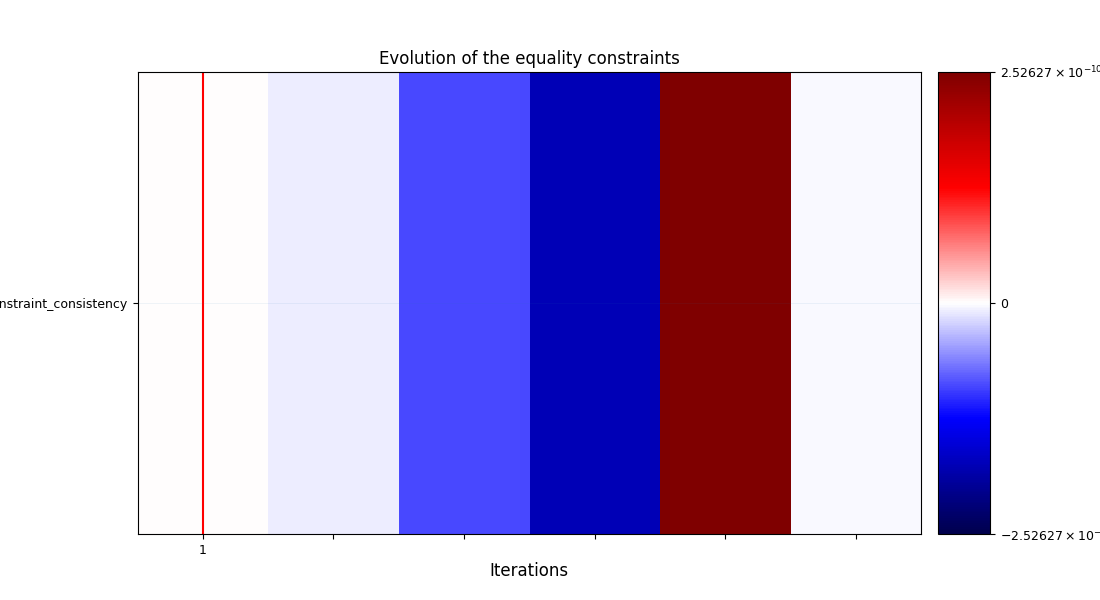

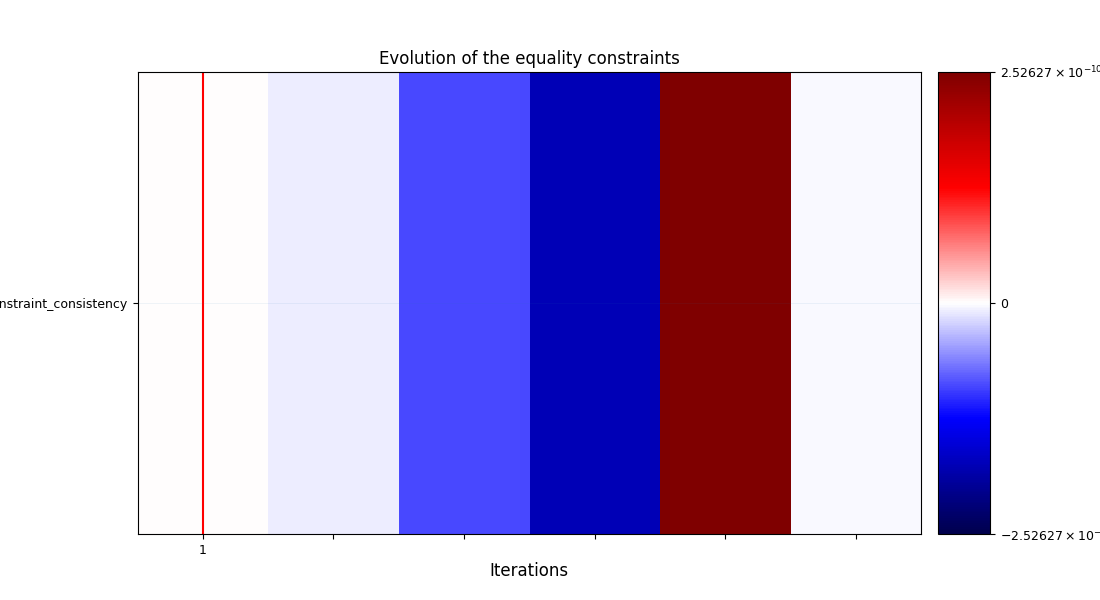

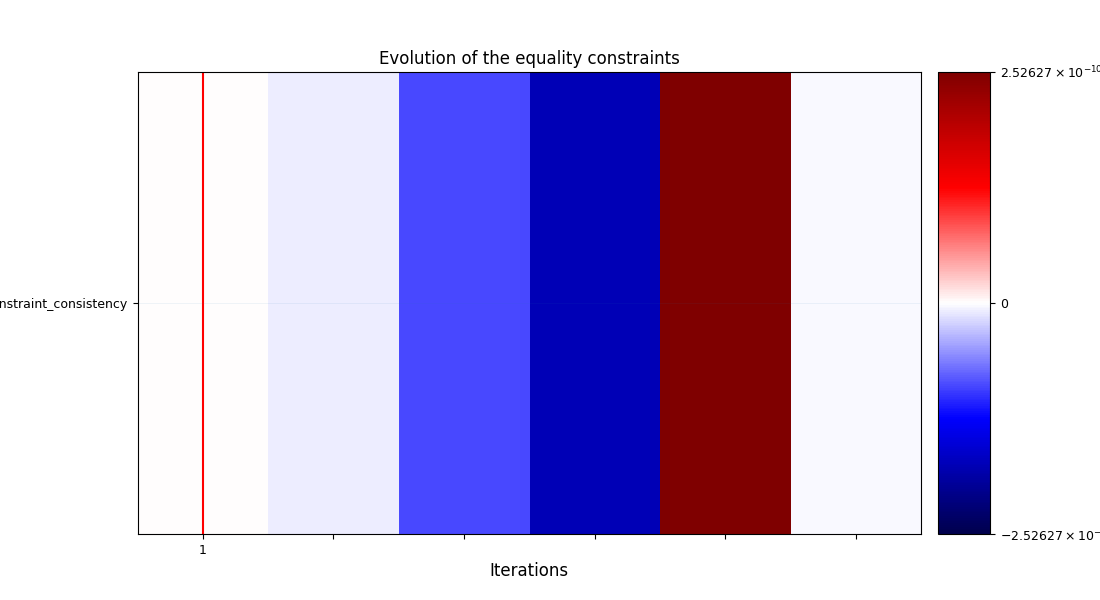

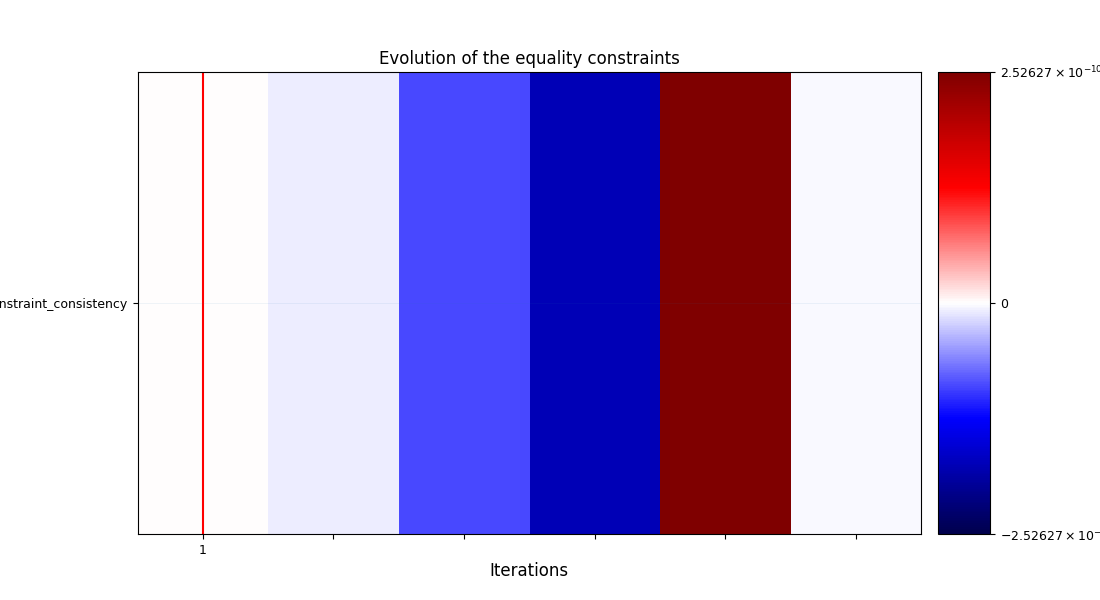

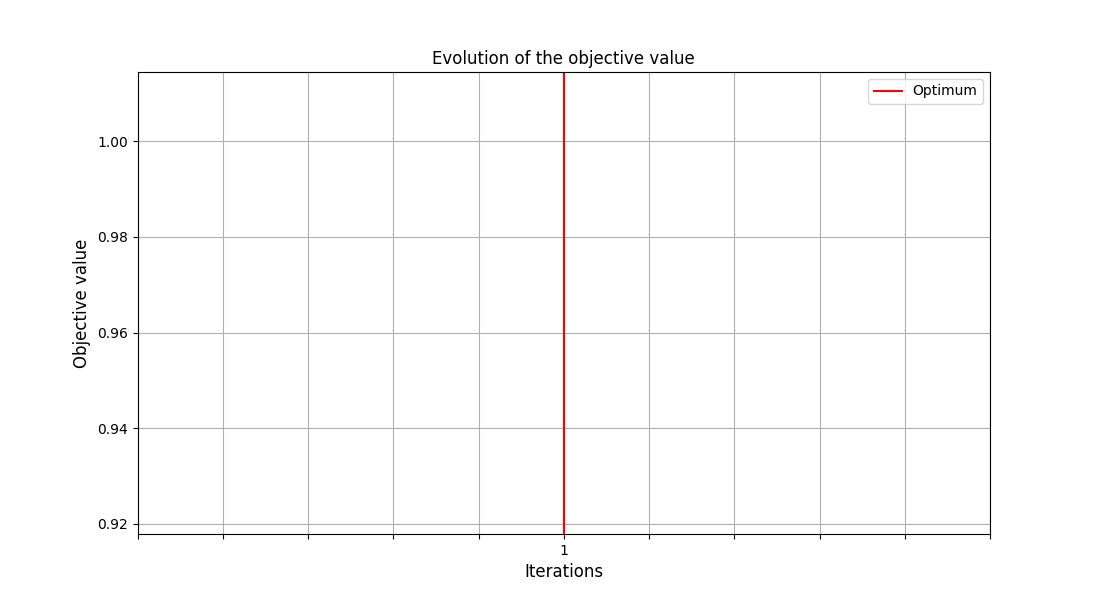

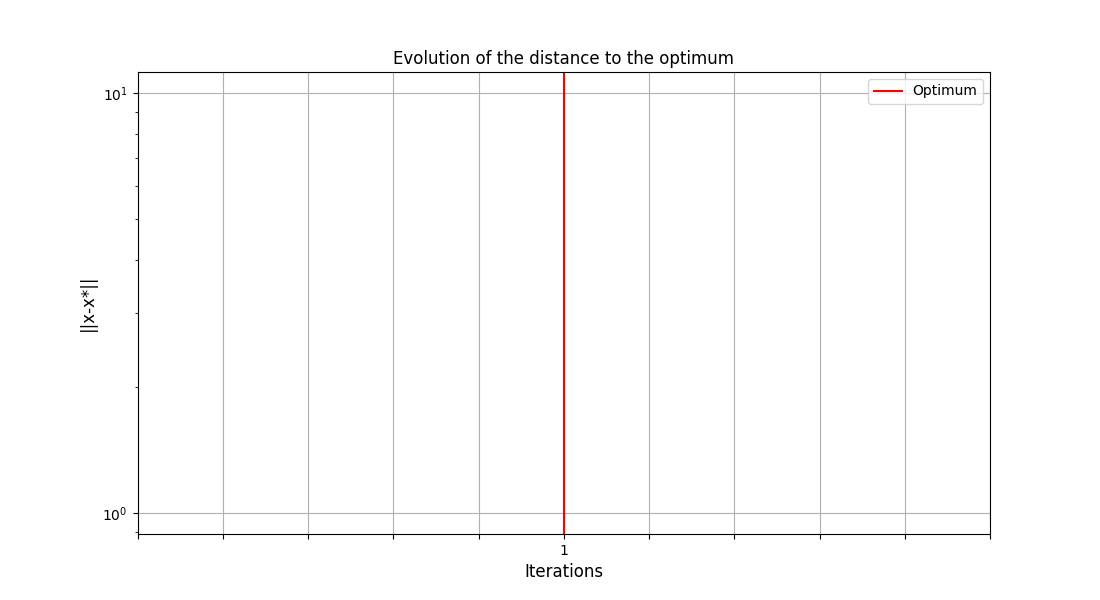

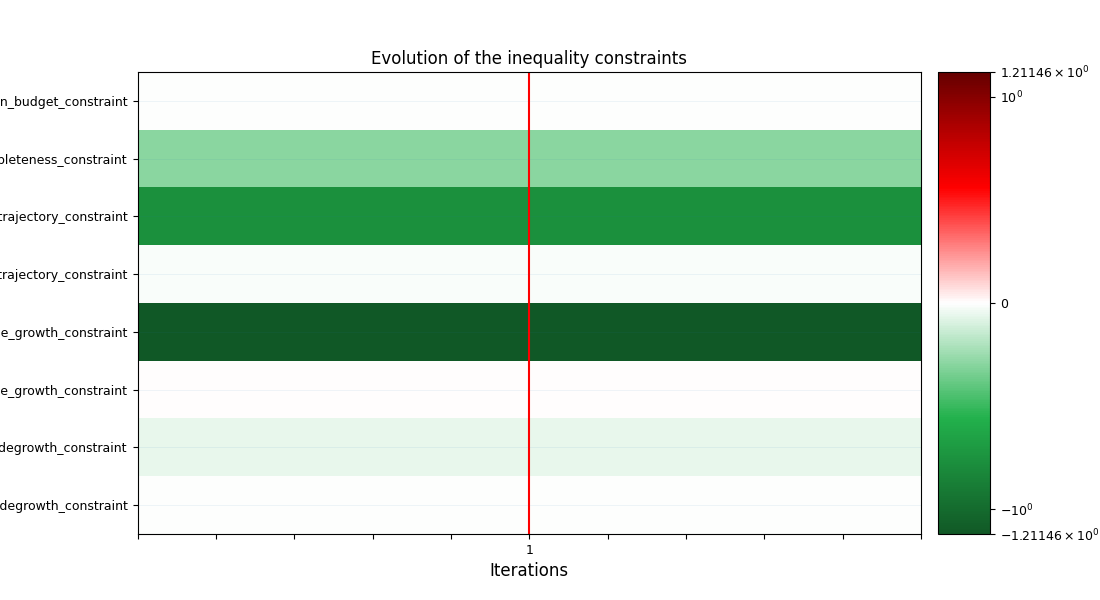

In [24]:
process.scenario.post_process("OptHistoryView", save=False, show=True)

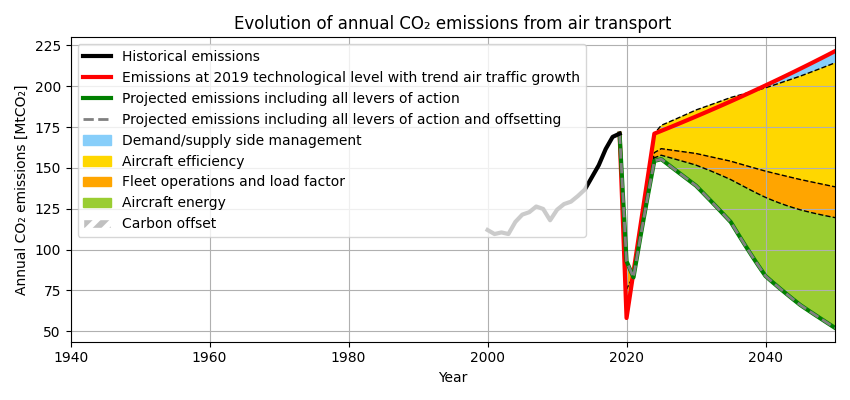

In [25]:
process.plot("air_transport_co2_emissions")

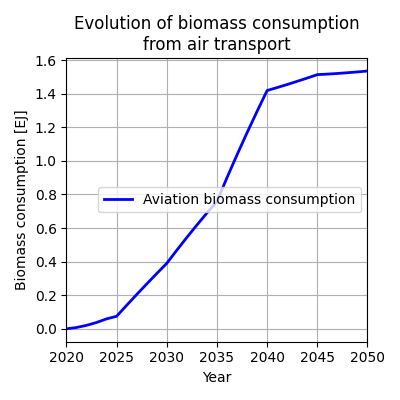

In [26]:
process.plot("biomass_consumption")

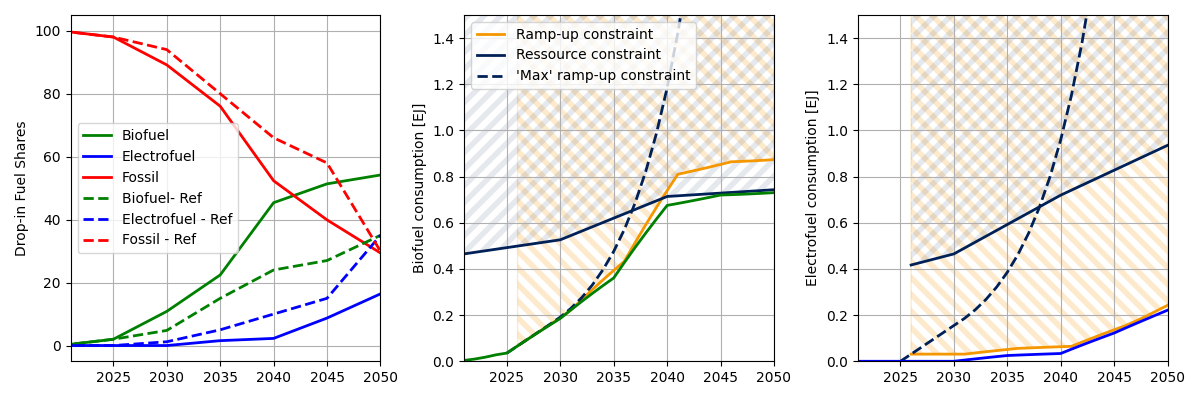

In [27]:
fig, [ax1, ax2, ax3] = plt.subplots(1, 3, figsize=(12, 4))

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "biofuel_share"],
    color="green",
    linestyle="-",
    label="Biofuel",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "electrofuel_share"],
    color="blue",
    linestyle="-",
    label="Electrofuel",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "kerosene_share"],
    color="red",
    linestyle="-",
    label="Fossil",
    linewidth=2,
)


ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 2, 4.8, 15, 24, 27, 35],
    color="green",
    linestyle="--",
    label="Biofuel- Ref",
    linewidth=2,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 0, 1.2, 5, 10, 15, 35],
    color="blue",
    linestyle="--",
    label="Electrofuel - Ref",
    linewidth=2,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [100, 98, 94.0, 80, 66, 58, 30],
    color="red",
    linestyle="--",
    label="Fossil - Ref",
    linewidth=2,
)


ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021, 2050)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_biofuel_growth_constraint_viz"
    ]
    / 1e12,
    color="#F59700",
    linestyle="-",
    label="Ramp-up constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_biofuel_growth_constraint_viz"
    ]
    / 1e12,
    3,
    hatch="\\\\",
    edgecolor="#F59700",
    facecolor="none",
    alpha=0.2,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_max_availability_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="-",
    label="Ressource constraint",
    linewidth=2,
)

ax2.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_max_availability_viz"
    ]
    / 1e12,
    3,
    hatch="//",
    edgecolor="#002157",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "biofuel_growth_constraint_theoretical_max_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="--",
    label="'Max' ramp-up constraint",
    linewidth=2,
)


ax2.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "energy_consumption_biofuel"
    ]
    / 1e12,
    color="green",
    linestyle="-",
    # label="Aviation biofuel consumption",
    linewidth=2,
)


ax2.grid()
# ax2.set_xlabel("Year")
ax2.set_ylabel("Biofuel consumption [EJ]")
ax2.legend(loc="upper left")
ax2.set_xlim(2021, 2050)
ax2.set_ylim(0, 1.5)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_electrofuel_growth_constraint_viz"
    ]
    / 1e12,
    color="#F59700",
    linestyle="-",
    # label="Electrofuel ramp-up constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "annual_electrofuel_growth_constraint_viz"
    ]
    / 1e12,
    3,
    hatch="\\\\",
    edgecolor="#F59700",
    facecolor="none",
    alpha=0.2,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "electrofuel_max_availability_viz"
    ]
    / 1e12,
    color="#002157",
    linestyle="-",
    # label="Electricity availability constraint",
    linewidth=2,
)

ax3.fill_between(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "electrofuel_max_availability_viz"
    ]
    / 1e12,
    3,
    hatch="//",
    edgecolor="#002157",
    facecolor="none",
    linewidth=0,
    alpha=0.1,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"],
        "electrofuel_growth_constraint_theoretical_max_viz",
    ]
    / 1e12,
    color="#002157",
    linestyle="--",
    # label="Electrofuel theoretical max ramp-Up constraint",
    linewidth=2,
)


ax3.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[
        process.data["years"]["prospective_years"], "energy_consumption_electrofuel"
    ]
    / 1e12,
    color="blue",
    linestyle="-",
    # label="Aviation electrofuel consumption",
    linewidth=2,
)


ax3.grid()
ax3.set_ylabel("Electrofuel consumption [EJ]")
ax3.set_xlim(2021, 2050)
ax3.set_ylim(0, 1.5)

fig.tight_layout()
fig.savefig("ressource_constraints.png", dpi=800)

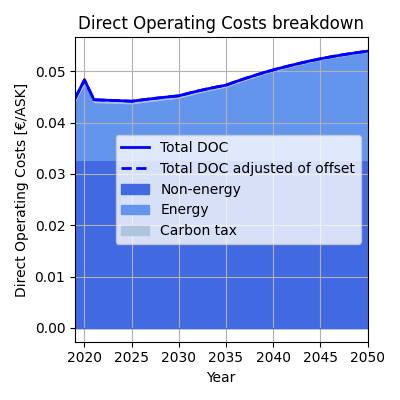

In [28]:
process.plot("doc_fleet_breakdown")

In [29]:
process.vector_outputs_df["cumulative_co2_emissions"][2050]

3.2186548706070295

In [30]:
process.vector_outputs_df["co2_emissions_including_energy"][2050]

52.08517724188241

In [31]:
process.vector_outputs_df["cumulative_total_airline_cost_discounted"][2050]

4601129974259.339

In [32]:
max(process.vector_outputs_df["electricity_consumption"].dropna())

0.5065989747225434

In [33]:
sum(process.vector_outputs_df["electricity_consumption"].dropna())

3.611361167128688

In [34]:
max(process.vector_outputs_df["biomass_consumption"].dropna())

1.5344183785766743

In [35]:
sum(process.vector_outputs_df["biomass_consumption"].dropna())

25.415110417581793

<Axes: >

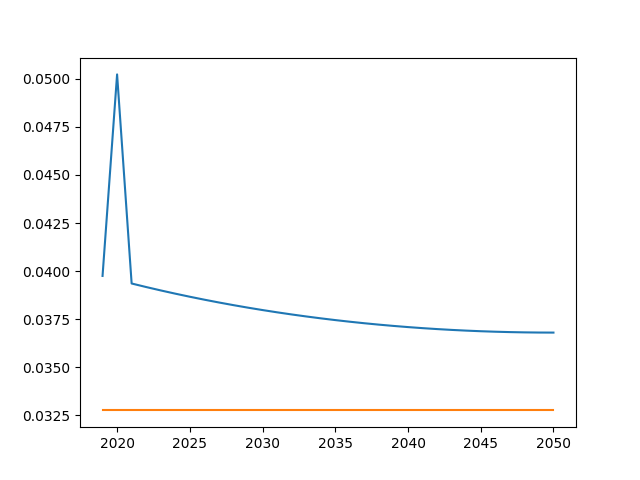

In [36]:
fig = plt.subplots()
plt.clf()
a = process.vector_outputs_df["doc_non_energy_per_ask_mean"].loc[2019:2050] / (
    process.vector_outputs_df["load_factor"].loc[2019:2050] / 100
)
a.plot()
process.vector_outputs_df["doc_non_energy_per_ask_mean"].loc[2019:2050].plot()

<Axes: >

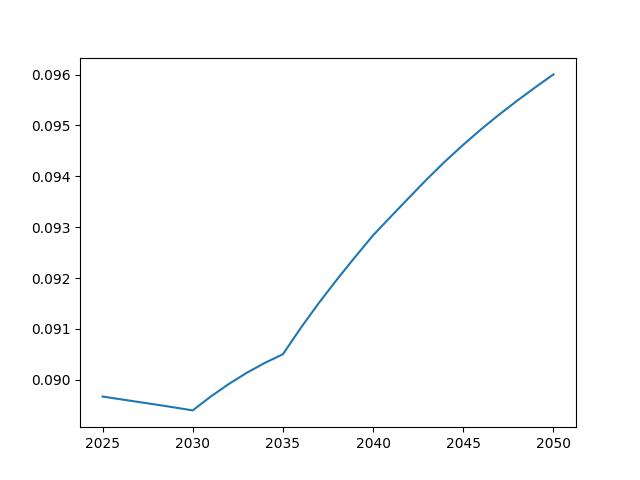

In [37]:
plt.clf()
fig = plt.subplots()
process.vector_outputs_df["airfare_per_rpk_true"].loc[2025:2050].plot()

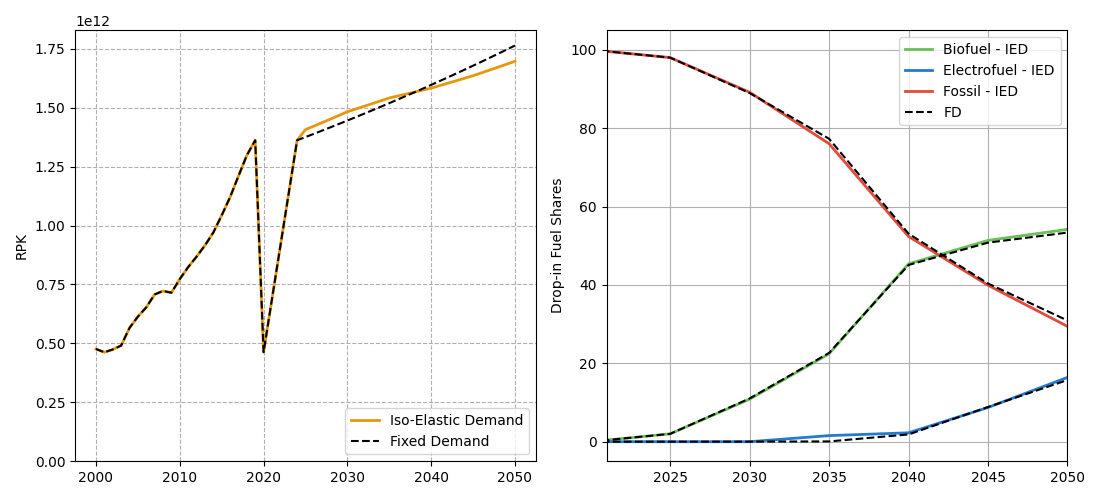

In [38]:
fig, [ax, ax1] = plt.subplots(1, 2, figsize=(11, 5))
plt.cla()
process.vector_outputs_df["rpk"].loc[2000:2050].plot(
    label="Iso-Elastic Demand", color="#E7970D", ls="-", ax=ax, linewidth=2
)
process.vector_outputs_df["rpk_no_elasticity"].loc[2000:2050].plot(
    color="black", ls="--", label="Fixed Demand", ax=ax, linewidth=1.5
)
ax.set_ylabel("RPK")
ax.set_ylim(
    0,
)
ax.legend(loc="lower right")
ax.grid(ls="--")

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "biofuel_share"],
    color="#6BBF59",
    linestyle="-",
    label="Biofuel - IED",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "electrofuel_share"],
    color="#2679D1",
    linestyle="-",
    label="Electrofuel - IED",
    linewidth=2,
)

ax1.plot(
    process.data["years"]["prospective_years"],
    process.vector_outputs_df.loc[process.data["years"]["prospective_years"], "kerosene_share"],
    color="#E24A3C",
    linestyle="-",
    label="Fossil - IED",
    linewidth=2,
)


ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 2, 11.02945021, 22.64991278, 45.09265767, 50.79100536, 53.35073021],
    color="black",
    linestyle="--",
    label="FD",
    linewidth=1.5,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [0, 0, 1.53876061e-02, 6.69531291e-02, 1.84765061e00, 8.85047992e00, 1.57302626e01],
    color="black",
    linestyle="--",
    linewidth=1.5,
)

ax1.plot(
    [2020, 2025, 2030, 2035, 2040, 2045, 2050],
    [100.0, 98.0, 88.95516218, 77.28313409, 53.05969172, 40.35851472, 30.91900719],
    color="black",
    linestyle="--",
    linewidth=1.5,
)


ax1.grid()
ax1.legend()
ax1.set_ylabel("Drop-in Fuel Shares")
ax1.set_xlim(2021, 2050)
fig.tight_layout()
fig.savefig("rpk_elasticity_effect.pdf")